In [1]:
!pip install chess

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install stockfish

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 

# list each folder of folder "games"
# get all folders
folders = glob.glob("games/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue

    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()

    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value
    
    
   

    # number of moves
    game_length = len(list(game.mainline_moves()))

    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]

    # get the Elo of the engine (if any)

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
                
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # replace append with concat
    new_row = pd.DataFrame([{
        "white": white,
        "black": black,
        "white_elo": white_elo,
        "black_elo": black_elo,
        "result": result,
        "nmoves": game_length,
        "nstarting_move": nmove_value,
        "pgn_base": pgn_base,
        "temperature": temperature,
        "random_engine": random_engine,
        "has_illegal": has_illegal,
        "illegal_move": illegal_move,
        "folder_name": folder
    }])
    df = pd.concat([df, new_row], ignore_index=True)

    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...


No game.pgn in games/game34fad7dd-e598-4969-9ac2-ab745885f0ee
No game.pgn in games/game1a570601-11a1-4bb2-bf14-ba8b4eeef40f
No game.pgn in games/game1503b2e5-e815-49e1-b1bf-14d9b02e3067
No game.pgn in games/gameb8966a66-5767-4b1d-be36-388a6f669efa
No game.pgn in games/gameb134bc87-b178-4031-a7ef-5d63e85830f6
No game.pgn in games/gameda5b7902-6ab2-43f9-8236-79bc9a2e0633


In [9]:
import re

# Open and read the content of metainformation.txt
with open("games/gamea7e73056-951a-417d-b671-0a60fba939f7/" + 'metainformation.txt', 'r') as file:
    content = file.read()

# Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
match = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)

if match:
    # Extract and clean up the matched content
    extracted_content = match.group(1).strip()
    print(extracted_content)
else:
    print('No match found')

0


In [10]:
print(len(df), "games compiled in the database")

878 games compiled in the database


In [11]:
import chess
import chess.pgn
import io 


# for column "pgn_base", I'd like to transform the string into a list of moves

def pgn_to_list(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    g.mainline_moves()
    return str(g.mainline_moves())

def is_base_prompt(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    # [Event "FIDE World Championship Match 2024"]\n[Site "Los Angeles, USA"]
    return g.headers["Event"] == "FIDE World Championship Match 2024" and g.headers["Site"] == "Los Angeles, USA"

def has_illegal_moves(pgn):
    # exist g.headers["UnknownSAN"] 
    g = chess.pgn.read_game(io.StringIO(pgn))
    # key in array
    return "UnknownSAN" in g.headers

df["pgn_base_moves"] = df["pgn_base"].apply(pgn_to_list) # extract only moves
df["base_pgn_prompt"] = df["pgn_base"].apply(is_base_prompt) # extract only prompt
# df.sort_values(by=['nstarting_move'])
df['temperature'] = pd.to_numeric(df['temperature'])

In [12]:
# Frequencies based on piece colors
players = ['gpt-3.5-turbo-instruct', 'gpt-4', 'gpt-3.5-turbo', 'text-davinci-003']
color_breakdown = {}
for player in players:
    white_count = df[df['white'] == player].shape[0]
    black_count = df[df['black'] == player].shape[0]
    color_breakdown[player] = {'white': white_count, 'black': black_count}

for player in players:
    nwhite = color_breakdown[player]['white']
    nblack = color_breakdown[player]['black']
    print(" *", player, ":", nwhite+nblack, "games, among", nwhite, "with white piece and", nblack, "with black pieces")


 * gpt-3.5-turbo-instruct : 573 games, among 401 with white piece and 172 with black pieces
 * gpt-4 : 179 games, among 116 with white piece and 63 with black pieces
 * gpt-3.5-turbo : 53 games, among 53 with white piece and 0 with black pieces
 * text-davinci-003 : 73 games, among 43 with white piece and 30 with black pieces


In [13]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4,Stockfish,?,1871,*,26,1,It is your turn! You have white pieces. Please...,0.0,False,True,Rxe8,games/gameb1500052-f572-46c1-953f-f1ce35b85d90,,False
1,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1-0,35,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game0ef565cf-24b7-4514-b8f6-286a0c205e15,,True
2,gpt-4,RANDOM chess engine,?,?,1-0,39,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game2869bc09-4bb0-42fa-af2f-c8780ba3fa4b,,False
3,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,34,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game52d0e78b-e22f-40b4-b50b-81da4155df26,1. f4 h5 2. Na3 g5 3. b3 a5 4. c4 Na6 5. Kf2 h...,True
4,gpt-3.5-turbo-instruct,Stockfish,?,1694,0-1,160,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game6d27c5fc-4ded-49ca-9d6d-803b7a550b25,,True


In [14]:
df.to_csv("games_db.csv")

In [15]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-3.5-turbo-instruct
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_black = df[(df['black'] == model_name) & (df['result'] == '1-0')].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)


text-davinci-003 (completion)

In [16]:
df_davinci = df.query("white == 'text-davinci-003' or black == 'text-davinci-003'")
print(len(df_davinci), "games with davinci")
print("with white pieces", len(df.query("white == 'text-davinci-003'")))
print("with black pieces", len(df.query("black == 'text-davinci-003'")))

print(len(df_davinci.query("white == 'RANDOM chess engine' or black == 'RANDOM chess engine'")), "games against random chess engine")
# print(compute_score(df_davinci.query("white == 'RANDOM chess engine' or black == 'RANDOM chess engine'"), "text-davinci-003"))


print(len(df_davinci.query("has_illegal == True")), "games with illegal move")
print("score", compute_score(df_davinci, "text-davinci-003"))

print("the only game with no illegal move is")
df_davinci.query("has_illegal == False")


# box plot of df_davinci['nmoves']
print("The longest game was", df_davinci['nmoves'].max()/2, "moves")
print("The shortest game was", df_davinci['nmoves'].min()/2, "moves")
print("The average game length was", df_davinci['nmoves'].mean()/2, "moves")
print("The median game length was", df_davinci['nmoves'].median()/2, "moves")



73 games with davinci
with white pieces 43
with black pieces 30
21 games against random chess engine
72 games with illegal move
score 0.0
the only game with no illegal move is
The longest game was 20.0 moves
The shortest game was 4.5 moves
The average game length was 12.027397260273972 moves
The median game length was 11.5 moves


In [17]:
df.sort_values(by=['pgn_base'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4,Stockfish,?,1871,*,26,1,It is your turn! You have white pieces. Please...,0.0,False,True,Rxe8,games/gameb1500052-f572-46c1-953f-f1ce35b85d90,,False
469,gpt-4,Stockfish,?,1871,0-1,188,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/gamee7ffcf1b-3db2-466c-a947-6c89952e47bb,,False
462,gpt-4,RANDOM chess engine,?,?,1-0,37,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/gamebc4c3d9d-fd5b-4747-931b-3a293eb919ba,,False
461,gpt-4,Stockfish,?,1871,0-1,78,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/game0e382b60-ed4f-4f85-84f0-d169a995a6de,,False
439,Stockfish,gpt-4,1871,?,*,93,1,It is your turn! You have white pieces. Please...,0.0,False,True,Bxf6,games/gamec17f1587-1d51-4090-af8b-9878837d3572,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,50,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game7c6ca350-54c6-4ec0-856d-3a69cd708779,1. h3 Nf6 2. a3 Na6 3. d4 h6 4. Bd2 g5 5. g3 R...,True
521,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,50,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game794ba31b-dd5d-4db5-8578-3ef1e3024f61,1. h3 e6 2. d4 Ke7 3. Bd2 f6 4. d5 Kd6 5. Be3 ...,True
212,gpt-3.5-turbo-instruct,Stockfish,?,1785,0-1,130,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game68a6373b-7275-4517-9efc-1baf7205ed7e,1. h3 g6 2. g3 c6 3. Bg2 e6 4. e4 d5 5. Nc3 Qb...,True
275,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,138,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game9e225b87-958f-42c7-862c-e8cf2c331a39,1. h4 Na6 2. b4 c5 3. Nf3 g5 4. Rh3 d6 5. d3 N...,True


In [18]:
df.sort_values(by=['white_elo'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
438,Stockfish,text-davinci-003,1694,?,*,21,1,"[Event ""Chess tournament""]\n[Site ""Rennes FRA""...",0.0,False,True,Nd7,games/gamee12e1aa5-0d1e-4bf3-852f-e001db630308,,False
427,Stockfish,text-davinci-003,1694,?,*,37,1,"[Event ""Chess tournament""]\n[Site ""Rennes FRA""...",0.0,False,True,Rae8,games/gameb08953cc-3eb8-446f-819d-476a30fae6cb,,False
837,Stockfish,text-davinci-003,1694,?,*,23,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Bg7,games/game08eac83e-807b-433c-8b15-4a89b1e9bbca,,True
49,Stockfish,text-davinci-003,1694,?,*,23,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Nbd7,games/game3dc25955-c098-400c-ab6a-e0cb5d1535b9,,True
97,Stockfish,text-davinci-003,1694,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Nb4,games/game7a423e09-9ffa-4e1b-a25c-163549435f80,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,gpt-3.5-turbo-instruct,Stockfish,?,1871,1-0,89,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/gamefe5f154d-2de1-409c-8e64-550def43ea39,,True
330,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1-0,27,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game1c863745-2c56-4006-a59e-681362cb2f32,,True
331,gpt-3.5-turbo-instruct,Stockfish,?,1785,0-1,42,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game66b23efd-001d-4342-8144-d000024c5bc3,1. Na3 a6 2. h3 f6 3. Nb1 h5 4. d4 Rh6 5. Qd3 ...,True
365,gpt-3.5-turbo,Stockfish,?,1694,*,22,1,It is your turn! You have white pieces. Please...,0.0,False,True,Bh4,games/game3af69992-0ddc-41d3-b867-c394dbc2ba5b,,False


GPTs against random engine 

In [19]:
df_random = df.query("random_engine == True")
df_random

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
1,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1-0,35,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game0ef565cf-24b7-4514-b8f6-286a0c205e15,,True
2,gpt-4,RANDOM chess engine,?,?,1-0,39,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game2869bc09-4bb0-42fa-af2f-c8780ba3fa4b,,False
5,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1/2-1/2,47,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game18d6ab87-e8c6-4d5c-8176-82cd72e9d542,,True
7,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1-0,43,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game711f2aed-5707-405a-82ac-98263bad2500,,True
8,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,*,16,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,True,cxd8=,games/game8fd3c2eb-1967-4793-8647-1b9a6cd21acd,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,gpt-4,RANDOM chess engine,?,?,1-0,25,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game20656fb3-8316-4d8e-92ea-4d508ec51101,,False
824,gpt-4,RANDOM chess engine,?,?,1-0,47,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/gamefd56635a-989e-4ce9-80d6-8e64c61eeeb8,,False
825,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1-0,45,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game95681c1a-56ac-4cc1-ba7a-160893146373,,True
832,gpt-3.5-turbo-instruct,RANDOM chess engine,?,?,1-0,7,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,True,False,,games/game16e5fb79-e763-41a4-a44c-d41a01dde2b8,,True


Score 98.89 % for games with only legal moves
Score 44.5  for games with only legal moves ( 45 games)
The only not won game is: https://lichess.org/bE99x52y is due to repetition
45 legal games and 16 illegal games (out of 61 total games)
Illegal moves are illegal_move
          45
hxg8=      4
gxh8=      3
{[%clk     2
cxd8=      1
{The       1
bxc1=      1
exf8=      1
gxf8=      1
gxh1=      1
dxc8=      1
Name: count, dtype: int64
Number of moves against random chess engine
The longest game was 33.0 moves
The shortest game was 2.0 moves
The average game length was 14.4 moves
The median game length was 14.0 moves
300    games/game53ab030a-eac5-4e07-b9ac-b5bea986a4db
219    games/game1c647bc0-c1c2-4ad9-8768-7855ae92409f
832    games/game16e5fb79-e763-41a4-a44c-d41a01dde2b8
820    games/gamec425a3ab-71c9-4da3-a8c8-ea448ac49ee4
507    games/game2d2ca7b6-6776-4dca-9514-edaa8b061e44
806    games/gamed9d33ce5-eb88-4196-a26d-02c9006851af
419    games/game86c3db5b-1bf9-48c6-a5e8-cfaf57e749ff

/tmp/ipykernel_128563/649191251.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(vals35[0], "legal games and", vals35[1], "illegal games", "(out of", vals35[0] + vals35[1], "total games)")
/tmp/ipykernel_128563/649191251.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(vals35[0], "legal games and", vals35[1], "illegal games", "(out of", vals35[0] + vals35[1], "total games)")


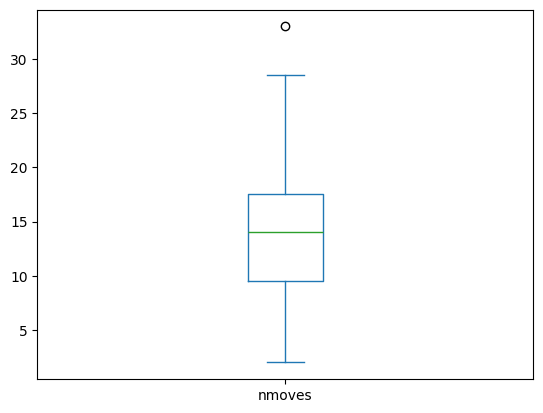

In [20]:
gpt35_instruct_legal_games = df_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and has_illegal == False")
score35 = compute_score(gpt35_instruct_legal_games, model_name='gpt-3.5-turbo-instruct') #['illegal_move'].value_counts()
print("Score", round(100*score35, 2), "% for games with only legal moves")

score, t = compute_score(gpt35_instruct_legal_games, model_name='gpt-3.5-turbo-instruct', percentage=False)
print("Score", score, " for games with only legal moves (", t, "games)")

print("The only not won game is:", "https://lichess.org/bE99x52y", "is due to repetition")

vals35 = df_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")['has_illegal'].value_counts()
print(vals35[0], "legal games and", vals35[1], "illegal games", "(out of", vals35[0] + vals35[1], "total games)")

print("Illegal moves are", df_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")['illegal_move'].value_counts())

print("Number of moves against random chess engine")
print("The longest game was", gpt35_instruct_legal_games['nmoves'].max()/2, "moves")
print("The shortest game was", gpt35_instruct_legal_games['nmoves'].min()/2, "moves")
print("The average game length was", gpt35_instruct_legal_games['nmoves'].mean()/2, "moves")
print("The median game length was", gpt35_instruct_legal_games['nmoves'].median()/2, "moves")

print(gpt35_instruct_legal_games.sort_values(by="nmoves", ascending=True)['folder_name'])

(gpt35_instruct_legal_games['nmoves'] / 2).plot(kind='box')


#### same for gpt-3.5-turbo 
gpt35_legal_games = df_random.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo') and has_illegal == False")
score35 = compute_score(gpt35_legal_games, model_name='gpt-3.5-turbo') #['illegal_move'].value_counts()
print("Score", round(100*score35, 2), "% for games with only legal moves")

vals35 = df_random.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")['has_illegal'].value_counts()
print(vals35[0], "legal games and", vals35[1], "illegal games", "(out of", vals35[0] + vals35[1], "total games)")

print("Illegal moves are", df_random.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")['illegal_move'].value_counts())
print("Quite severe example:", "https://lichess.org/FMoHsC7m", "with Bxd6") # gameb5a17c54-fc9b-4a55-867b-ca61800ba228)

In [21]:
df_non_random = df.query("random_engine == False and nstarting_move <= 2")

def analyze_model_performance(df_m, model_gpt_name):    

    print(f"Analysis against SF (no random engine, no random first moves) for model: {model_gpt_name}")

    model_games = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == False")
    score_model = compute_score(model_games, model_name=model_gpt_name)
    print("Score", round(100*score_model, 2), "% for games with only legal moves")
    score, t = compute_score(model_games, model_name=model_gpt_name, percentage=False)
    print("Score", score, "for games with only legal moves (", t, "games)")

    tot = len(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')"))
    print("Score", round(100*(score/tot), 2), "% for all games, being legal or illegal")
    print("Score", score, "for all games (", tot, "games)")

    vals_model = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")['has_illegal'].value_counts()
    ntot = vals_model.get(0, 0) + vals_model.get(1, 0)

    print("Out of", ntot ,"games against SF,", vals_model.get(0, 0), "were legal games and", vals_model.get(1, 0), "were illegal games, hence", round((vals_model.get(1, 0)/ntot)*100), "% of illegal games.")
    print(vals_model.get(0, 0), "legal games and", vals_model.get(1, 0), "illegal games", "(out of", ntot, "total games)")
    print(round((vals_model.get(1, 0)/ntot)*100), "% of illegal games")

    print("Illegal moves are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True")['illegal_move'].value_counts().to_markdown())

    print("Illegal moves with n first random move are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True and nstarting_move > 2")['illegal_move'].value_counts().to_markdown())

# Example usage:
# analyze_model_performance(df_non_random, 'gpt-3.5-turbo-instruct')
# analyze_model_performance(df_non_random, 'gpt-4')

# analyze_model_performance(df_random, 'gpt-4')

analyze_model_performance(df_random, 'gpt-3.5-turbo')



Analysis against SF (no random engine, no random first moves) for model: gpt-3.5-turbo
Score 100.0 % for games with only legal moves
Score 6.0 for games with only legal moves ( 6 games)
Score 26.09 % for all games, being legal or illegal
Score 6.0 for all games ( 23 games)
Out of 23 games against SF, 17 were legal games and 6 were illegal games, hence 26 % of illegal games.
17 legal games and 6 illegal games (out of 23 total games)
26 % of illegal games
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| fxg8=Q         |       1 |
| Qxf8#          |       1 |
| dxe6           |       1 |
| Qxd8+          |       1 |
| Bxd6           |       1 |
| Nf7+           |       1 |
| fxg7           |       1 |
| cxd6           |       1 |
| gxh8=Q         |       1 |
| Qd5            |       1 |
| hxg8=Q         |       1 |
| Qe2#           |       1 |
| fxg6           |       1 |
| exf6           |       1 |
| Bxg8           |       1 |
| Nxf6#          |       1 |
|

/tmp/ipykernel_128563/1214297660.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ntot = vals_model.get(0, 0) + vals_model.get(1, 0)
/tmp/ipykernel_128563/1214297660.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Out of", ntot ,"games against SF,", vals_model.get(0, 0), "were legal games and", vals_model.get(1, 0), "were illegal games, hence", round((vals_model.get(1, 0)/ntot)*100), "% of illegal games.")
/tmp/ipykernel_128563/1214297660.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

In [22]:
def analyze_model_performance(df, gpt_model_name):
    df_non_random_with_random_first_moves = df.query("random_engine == False and nstarting_move > 2")

    print(f"Analysis against SF (no random engine, random first moves) for {gpt_model_name}")

    gpt_instruct_legal_games_with_random_first_moves = df_non_random_with_random_first_moves.query(f"(white == '{gpt_model_name}' or black == '{gpt_model_name}') and has_illegal == False")
    score = compute_score(gpt_instruct_legal_games_with_random_first_moves, model_name=gpt_model_name)
    print(f"Score {round(100*score, 2)}% for games with only legal moves")
    
    score, t = compute_score(gpt_instruct_legal_games_with_random_first_moves, model_name=gpt_model_name, percentage=False)
    print(f"Score {score} for games with only legal moves ({t} games)")

    tot = len(df_non_random_with_random_first_moves.query(f"(white == '{gpt_model_name}' or black == '{gpt_model_name}')"))
    print(f"Score {round(100*(score/tot), 2)}% for all games, being legal or illegal")
    print(f"Score {score} for all games ({tot} games)")

    vals = df_non_random_with_random_first_moves.query(f"(white == '{gpt_model_name}' or black == '{gpt_model_name}')")['has_illegal'].value_counts()
    ntot = vals.get(0, 0) + vals.get(1, 0)
    illegal_percentage = round((vals.get(1, 0)/ntot)*100) if ntot else 0

    print(f"Out of {ntot} games against SF, {vals.get(0, 0)} were legal games and {vals.get(1, 0)} were illegal games, hence {illegal_percentage}% of illegal games.")
    print(f"{vals.get(0, 0)} legal games and {vals.get(1, 0)} illegal games (out of {ntot} total games)")
    print(f"{illegal_percentage}% of illegal games")

    print("Illegal moves are:")
    print(df_non_random_with_random_first_moves.query(f"(white == '{gpt_model_name}' or black == '{gpt_model_name}') and has_illegal == True")['illegal_move'].value_counts().to_markdown())

    print(f"Illegal moves with n first random move are:")
    print(df_non_random_with_random_first_moves.query(f"(white == '{gpt_model_name}' or black == '{gpt_model_name}') and has_illegal == True and nstarting_move > 2")['illegal_move'].value_counts().to_markdown())

# Example usage:
analyze_model_performance(df, 'gpt-3.5-turbo-instruct')


Analysis against SF (no random engine, random first moves) for gpt-3.5-turbo-instruct
Score 9.15% for games with only legal moves
Score 6.5 for games with only legal moves (71 games)
Score 8.9% for all games, being legal or illegal
Score 6.5 for all games (73 games)
Out of 73 games against SF, 71 were legal games and 2 were illegal games, hence 3% of illegal games.
71 legal games and 2 illegal games (out of 73 total games)
3% of illegal games
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| Qxc6+          |       1 |
| Bc5            |       1 |
Illegal moves with n first random move are:
| illegal_move   |   count |
|:---------------|--------:|
| Qxc6+          |       1 |
| Bc5            |       1 |


/tmp/ipykernel_128563/2025860844.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ntot = vals.get(0, 0) + vals.get(1, 0)
/tmp/ipykernel_128563/2025860844.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  illegal_percentage = round((vals.get(1, 0)/ntot)*100) if ntot else 0
/tmp/ipykernel_128563/2025860844.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Out of {ntot} games against SF, {vals.get(0, 0)} were legal ga

In [23]:
len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')"))

439

In [24]:
def count_moves_and_illegals(df_l, gpt_model_name):
    illegal_white_moves = len(df_l.query(f"(white == '{gpt_model_name}') and has_illegal == True"))
    total_white_moves = len(df_l.query(f"(white == '{gpt_model_name}')"))
    total_black_moves = len(df_l.query(f"(black == '{gpt_model_name}')"))
    illegal_black_moves = len(df_l.query(f"(black == '{gpt_model_name}') and has_illegal == True"))

    print(illegal_white_moves, "illegal moves with white")
    print(total_white_moves)
    print(total_black_moves)
    print(illegal_black_moves, "illegal moves with black")

    return illegal_white_moves, total_white_moves, total_black_moves, illegal_black_moves

# count_moves_and_illegals(df_non_random, 'gpt-3.5-turbo-instruct')
count_moves_and_illegals(df_non_random, 'gpt-4')


15 illegal moves with white
54
40
15 illegal moves with black


(15, 54, 40, 15)

In [25]:
mask = (df_non_random["white"] == 'gpt-3.5-turbo-instruct') | (df_non_random["black"] == 'gpt-3.5-turbo-instruct')
illegal_gpt35vsSF_instruct = df_non_random.loc[mask & (df_non_random["has_illegal"] == True)].copy()
illegal_gpt35vsSF_instruct["temperature"] = illegal_gpt35vsSF_instruct["temperature"].astype(float)

print(illegal_gpt35vsSF_instruct[["temperature"]].value_counts())

t8 = len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `temperature` == '0.8'")) / len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')"))
print(round(100*t8, 2), "% of games with temperature 0.8")

print(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `temperature` == '0.8' and has_illegal == True")['illegal_move'].value_counts().to_markdown())


temperature
0.0            41
0.8            29
Name: count, dtype: int64
0.0 % of games with temperature 0.8
| illegal_move   | count   |
|----------------|---------|


In [26]:
illegal_gpt35vsSF_instruct = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and has_illegal == True") # [['pgn_base']].value_counts()
n = 0
m = 0
for i, row in illegal_gpt35vsSF_instruct.iterrows():
    if "Rennes FRA" in row["pgn_base"]:
        n = n + 1
    else:
        m = m + 1

print(len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and pgn_base.str.contains('Rennes FRA')")), "games with altered prompt")
print(len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and pgn_base.str.contains('Rennes FRA')")) / len(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")) * 100, "% games with altered prompt")

print(n, "illegal games with altered prompts and", m, "illegal games with original prompts")
print(illegal_gpt35vsSF_instruct.query("pgn_base.str.contains('Rennes FRA')")['illegal_move'].value_counts())

print(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and has_illegal == True")['nstarting_move'].value_counts().to_markdown())


99 games with altered prompt
22.55125284738041 % games with altered prompt
19 illegal games with altered prompts and 51 illegal games with original prompts
illegal_move
1-0      16
f7        1
bxc8=     1
bxc3      1
Name: count, dtype: int64
|   nstarting_move |   count |
|-----------------:|--------:|
|                1 |      70 |


In [27]:
print("Does random first moves impact?")
print(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")['nstarting_move'].value_counts().to_markdown())

Does random first moves impact?
|   nstarting_move |   count |
|-----------------:|--------:|
|                1 |     435 |
|                2 |       4 |


In [28]:
def count_invalid_games(df_l, model_gpt_name):
    query_str = f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True and illegal_move != '1-0' and illegal_move != '1-'"
    
    x = 0
    for _, r in df_l.query(query_str).iterrows():
        if '=' in r['illegal_move'] or '{' in r['illegal_move']:
            continue

        print(r['illegal_move'], r['folder_name'])
        x += 1 

    percentage = round(x / len(df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")), 3) * 100
    print(f'If we consider "1-0", "comments", and "unspecified promotions" as fixable, then {percentage} % are non valid games')

    return percentage

count_invalid_games(df_non_random, 'gpt-3.5-turbo-instruct')


    

f7 games/game6a45d413-1654-4995-957a-9219c82d2d74
Qa7 games/game359d97d4-0d8b-4494-9623-6ee8aad6f27b
Nxa3 games/game2adc58cf-0608-41b3-9b1c-523f74fb1e93
bxc3 games/game44815a7f-14ab-4be7-acf2-5b4dd20e3791
Kb3 games/game7f1ea428-7829-4cc2-ba9f-7c27810e7db9
Rxh5 games/game5f02a530-c7dd-4960-b182-4b5c844fa526
If we consider "1-0", "comments", and "unspecified promotions" as fixable, then 1.4000000000000001 % are non valid games


1.4000000000000001

In [29]:
import os

path_to_stockfish = os.path.expanduser("~/Documents/INSA/S9/REP/repV2chess/stockfish-ubuntu-x86-64-sse41-popcnt")

if os.path.exists(path_to_stockfish):
    print("Le fichier existe et est accessible !")
else:
    print("Le fichier est introuvable ou inaccessible.")

Le fichier existe et est accessible !


In [30]:
print("Qualitative analysis of illegal moves:")

import pandas as pd
from stockfish import Stockfish

# A list to store your data
data_list = []

illegal_moves10 = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and illegal_move == '1-0'")

for index, row in illegal_moves10.iterrows():
    if row['white'] == 'gpt-3.5-turbo-instruct':
        color = "White"
    else:
        color = "Black"

    # Read the PGN file
    with open(row['folder_name'] + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)

        stockfish = Stockfish("./stockfish-ubuntu-x86-64-avx2/stockfish/stockfish-ubuntu-x86-64-avx2")
        #stockfish = Stockfish("C:/Programmes/stockfish/stockfish-windows-x86-64-sse41-popcnt.exe")
        #stockfish = Stockfish("./stockfish/stockfish/stockfish-ubuntu-x86-64-avx2")
        stockfish.set_position([str(m) for m in game.mainline_moves()])
        ev = stockfish.get_evaluation()

        # Create an evaluation string
        if ev['type'] == 'cp':
            evaluation = str(ev['value'] / 100)
        else:
            evaluation = "Mate in " + str(ev['value'])

        # Add the dictionary directly to the list
        data_list.append({
            "GPT Color": color,
            "Assessment": evaluation
        })

# Convert the list of dictionaries into a dataframe
df_results = pd.DataFrame(data_list)

# If you want to see the first few rows of your dataframe:
print(df_results.to_markdown())


Qualitative analysis of illegal moves:
|    | GPT Color   | Assessment   |
|---:|:------------|:-------------|
|  0 | Black       | 5.68         |
|  1 | Black       | 7.61         |
|  2 | Black       | 7.36         |
|  3 | Black       | Mate in 4    |
|  4 | Black       | 6.35         |
|  5 | Black       | 7.62         |
|  6 | Black       | Mate in 1    |
|  7 | Black       | Mate in 5    |
|  8 | White       | Mate in -1   |
|  9 | Black       | Mate in 2    |
| 10 | Black       | 7.9          |
| 11 | Black       | 7.29         |
| 12 | Black       | 5.8          |
| 13 | Black       | 5.05         |
| 14 | Black       | 5.55         |
| 15 | Black       | Mate in 1    |
| 16 | Black       | 5.63         |
| 17 | Black       | 6.18         |
| 18 | Black       | Mate in 1    |
| 19 | Black       | 8.78         |
| 20 | Black       | 3.77         |
| 21 | Black       | 7.8          |
| 22 | Black       | Mate in 1    |
| 23 | Black       | 7.65         |
| 24 | Black       | Mate

In [31]:
df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct' and has_illegal == True)").sort_values(by="nmoves", ascending=False)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
72,gpt-3.5-turbo-instruct,Stockfish,?,1785,*,348,1,"[Event ""Chess tournament""]\n[Site ""Rennes FRA""...",0.0,False,True,f7,games/game6a45d413-1654-4995-957a-9219c82d2d74,,False
517,gpt-3.5-turbo-instruct,Stockfish,?,1871,1/2-1/2,290,1,"[Event ""Chess tournament""]\n[Site ""Rennes FRA""...",0.0,False,False,,games/game6ceeed32-b952-4496-a5ce-b8142eda01d2,,False
83,gpt-3.5-turbo-instruct,Stockfish,?,1785,1/2-1/2,275,1,"[Event ""Chess tournament""]\n[Site ""Rennes FRA""...",0.0,False,False,,games/game240bf989-a2c2-426a-9104-95b534b34b09,,False
699,gpt-3.5-turbo-instruct,Stockfish,?,1954,0-1,244,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game82b3bf36-96cc-4667-8331-3c221b9e7d61,,True
555,gpt-3.5-turbo-instruct,Stockfish,?,1785,0-1,244,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/game332c5a22-657d-48da-8c76-8e582629daaf,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,gpt-3.5-turbo-instruct,Stockfish,?,1871,*,28,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Nxa3,games/game2adc58cf-0608-41b3-9b1c-523f74fb1e93,,True
27,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,True,{M.,games/game051d6c13-e880-49d1-9aac-6f19b81a0c62,,True
131,Stockfish,gpt-3.5-turbo-instruct,1871,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,True,{(Leko-G,games/gameb34046f8-b640-49e0-9ef5-94f35774746b,,True
589,Stockfish,gpt-3.5-turbo-instruct,1871,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,True,{[%clk,games/game2ce2d311-6259-4bb9-bd60-db1b5d701042,,True


In [32]:
j = 0
cp_g = 0
for index, row in df_results.iterrows():
    if 'Mate' in row['Assessment']:
        j = j + 1
    elif float(row['Assessment']) > 5.0:
        cp_g = cp_g + 1

print(j, "games with mate", "out of", len(df_results), "games")
print(cp_g, "games with cp > 5.0", "out of", len(df_results), "games")
print(len(df_results) - (j+cp_g), "games with cp < 5.0", "out of", len(df_results), "games")



18 games with mate out of 49 games
26 games with cp > 5.0 out of 49 games
5 games with cp < 5.0 out of 49 games


illegal moves 0.6629999999999999 %
illegal_moves without 1-0: 0.6629999999999999 %
Total number of moves played by gpt-4 : 4527.0
White played 2672.5 moves
Black played 1854.5 moves
Number of moves against SF
The longest game was 128.5 moves
The shortest game was 13.0 moves
The average game length was 48.159574468085104 moves
The median game length was 45.75 moves


/tmp/ipykernel_128563/91490153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_games['nmoves'] = model_games['nmoves'] / 2


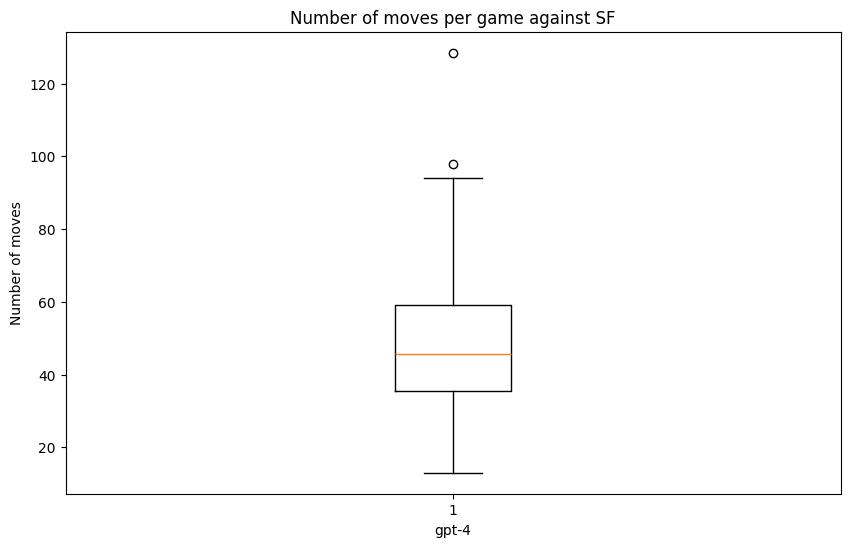

In [33]:
import matplotlib.pyplot as plt

def analyze_games(df_l, model_name):
    # Query for games played by the given model
    model_games = df_l.query(f"(white == '{model_name}' or black == '{model_name}')")
    model_games['nmoves'] = model_games['nmoves'] / 2
    
    # Sum of moves played by the model
    white_nmoves = df_l.query(f"white == '{model_name}'")['nmoves'].sum() / 2
    black_nmoves = df_l.query(f"black == '{model_name}'")['nmoves'].sum() / 2
    t_moves = model_games['nmoves'].sum()

    # Count of illegal moves
    illegal_moves = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True"))
    illegal_moves_10 = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True and illegal_move != '1-0'"))

    # Printing results
    print("illegal moves", round(illegal_moves/t_moves, 5)*100, "%")
    print("illegal_moves without 1-0:", round(illegal_moves_10/t_moves, 5)*100, "%")
    print("Total number of moves played by", model_name, ":", t_moves)
    print("White played", white_nmoves, "moves")
    print("Black played", black_nmoves, "moves")
    print("Number of moves against SF")
    print("The longest game was", model_games['nmoves'].max(), "moves")
    print("The shortest game was", model_games['nmoves'].min(), "moves")
    print("The average game length was", model_games['nmoves'].mean(), "moves")
    print("The median game length was", model_games['nmoves'].median(), "moves")

    # Plotting box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(model_games['nmoves'])
    plt.title(f"Number of moves per game against SF")
    plt.ylabel("Number of moves")
    plt.xlabel(f"{model_name}")
    plt.savefig(f"{model_name}_games_nmoves.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# analyze_games(df_non_random, 'gpt-3.5-turbo-instruct')
analyze_games(df_non_random, 'gpt-4')



In [34]:


#### same for gpt-3.5-turbo
gpt35_legal_games = df_non_random.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo') and has_illegal == False")
score35 = compute_score(gpt35_legal_games, model_name='gpt-3.5-turbo') #['illegal_move'].value_counts()
print("Score", round(100*score35, 2), "% for games with only legal moves")

vals35 = df_non_random.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")['has_illegal'].value_counts()
print(vals35[0], "legal games and", vals35[1], "illegal games", "(out of", vals35[0] + vals35[1], "total games)")

print("Illegal moves are", df_non_random.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")['illegal_move'].value_counts())

Score 0.0 % for games with only legal moves
28 legal games and 2 illegal games (out of 30 total games)
Illegal moves are illegal_move
Qxe4     2
         2
cxb7     2
cxd6     1
Nxe1     1
Qxf6     1
Rxf7+    1
Nxe5+    1
Bg8      1
Rxf6     1
Rd8      1
exf6     1
Nxd1     1
Qxf5     1
Bh4      1
Bxd6+    1
Nxf7+    1
O-O      1
Rxh6     1
Qxg5     1
Kxe1     1
Bxh6     1
exd6     1
c4       1
Bxc6     1
Rxh1     1
Bxf6     1
Name: count, dtype: int64


/tmp/ipykernel_128563/3049898785.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(vals35[0], "legal games and", vals35[1], "illegal games", "(out of", vals35[0] + vals35[1], "total games)")


439 games played against SF
369 legal games played against SF


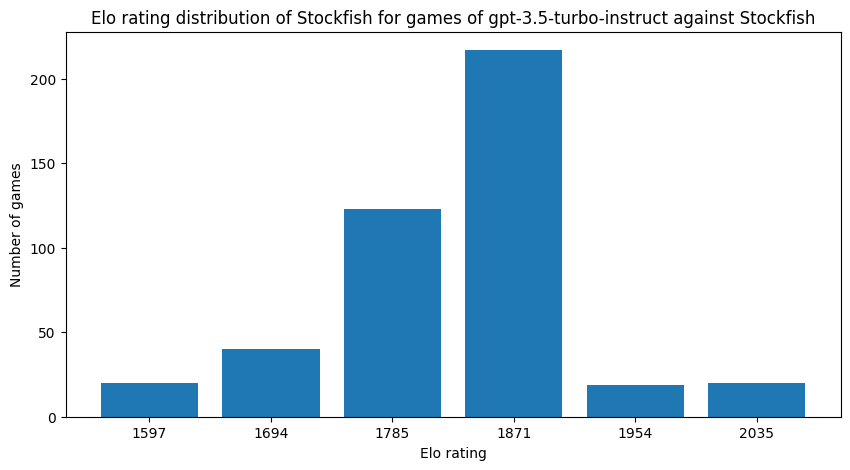

In [35]:
df_gpt35 = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")
print(len(df_gpt35), "games played against SF")
print(len(df_gpt35.query("has_illegal == False")), "legal games played against SF")

# Extracting elo values for games where Stockfish is playing against gpt-3.5-turbo-instruct
stockfish_black_elo_vs_gpt3_5_instruct = df_gpt35['black_elo']
# remove values with '?' value
stockfish_black_elo_vs_gpt3_5_instruct = stockfish_black_elo_vs_gpt3_5_instruct[stockfish_black_elo_vs_gpt3_5_instruct != '?']

stockfish_white_elo_vs_gpt3_5_instruct = df_gpt35['white_elo']
# remove values with '?' value
stockfish_white_elo_vs_gpt3_5_instruct = stockfish_white_elo_vs_gpt3_5_instruct[stockfish_white_elo_vs_gpt3_5_instruct != '?']


# Combining Elo ratings of Stockfish as both white and black player
combined_stockfish_elo = pd.concat([stockfish_white_elo_vs_gpt3_5_instruct, stockfish_black_elo_vs_gpt3_5_instruct])

import matplotlib.pyplot as plt

# Assuming you have already computed value counts
value_counts = combined_stockfish_elo.value_counts().sort_index()

# Plotting the histogram for combined Elo ratings
plt.figure(figsize=(10,5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Elo rating')
plt.ylabel('Number of games')
plt.title('Elo rating distribution of Stockfish for games of gpt-3.5-turbo-instruct against Stockfish')
plt.savefig("stockfish_elo_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [36]:
gpt4_legal_games = df_random.query("(white == 'gpt-4' or black == 'gpt-4') and has_illegal == False")
score4 = compute_score(gpt4_legal_games, model_name='gpt-4') #['illegal_move'].value_counts()
print("Score", round(100*score4, 2), "% for games with only legal moves")

print("The only not won game is:", "https://lichess.org/1A1IrIjO#74", "leads to stalemate in a completely winning position")

vals4 = df_random.query("(white == 'gpt-4' or black == 'gpt-4')")['has_illegal'].value_counts()
print(vals4[0], "legal games and", vals4[1], "illegal games", "(out of", vals4[0] + vals4[1], "total games)")

print("Illegal moves are", df_random.query("(white == 'gpt-4' or black == 'gpt-4')")['illegal_move'].value_counts())
print("Illegal moves are much more severe here! ie they are really illegal moves", "see eg https://lichess.org/k2MhW32K or https://lichess.org/lVIF2hvE#48")
print("This https://lichess.org/wFwTWWgh is more about ambigous move")

Score 99.15 % for games with only legal moves
The only not won game is: https://lichess.org/1A1IrIjO#74 leads to stalemate in a completely winning position
59 legal games and 26 illegal games (out of 85 total games)
Illegal moves are illegal_move
         59
12...     2
Qxc8#     1
Qh4#      1
Bxf8      1
16...     1
Bxa6      1
Qd7       1
exd8      1
cxd8      1
gxh8      1
14...     1
fxg7      1
exd2+     1
Qae8#     1
gxh7+     1
Rxg8      1
17...     1
Qh5       1
6.        1
Qd5+      1
Nxg4      1
5.        1
Qxd8      1
Qd4       1
9...      1
Name: count, dtype: int64
Illegal moves are much more severe here! ie they are really illegal moves see eg https://lichess.org/k2MhW32K or https://lichess.org/lVIF2hvE#48
This https://lichess.org/wFwTWWgh is more about ambigous move


/tmp/ipykernel_128563/2424594021.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(vals4[0], "legal games and", vals4[1], "illegal games", "(out of", vals4[0] + vals4[1], "total games)")


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

def plot_histogram(df):
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Plot histogram of nmoves
    sns.histplot(df['nmoves'], bins=30, kde=True, color="skyblue")

    # Set plot labels and title
    plt.xlabel('Number of Moves', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Number of Moves in Chess Games', fontsize=16)

    # Show the plot
    plt.show()

def plot_boxplot(df):
    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Create a boxplot of nmoves
    sns.boxplot(x=df['nmoves'], color="lightblue")

    # Set plot labels and title
    plt.xlabel('Number of Moves', fontsize=14)
    plt.title('Boxplot of Number of Moves in Chess Games', fontsize=16)

    # Show the plot
    plt.show()

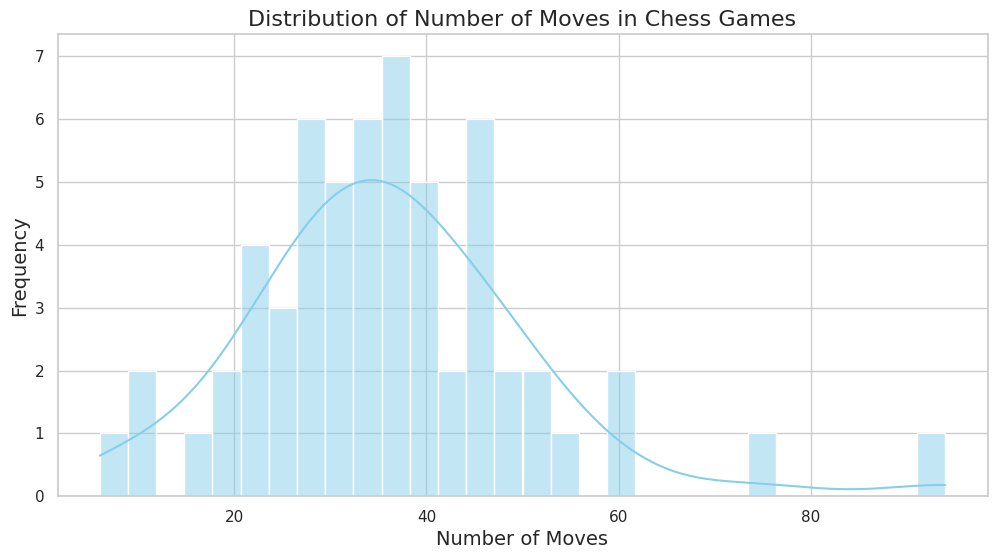

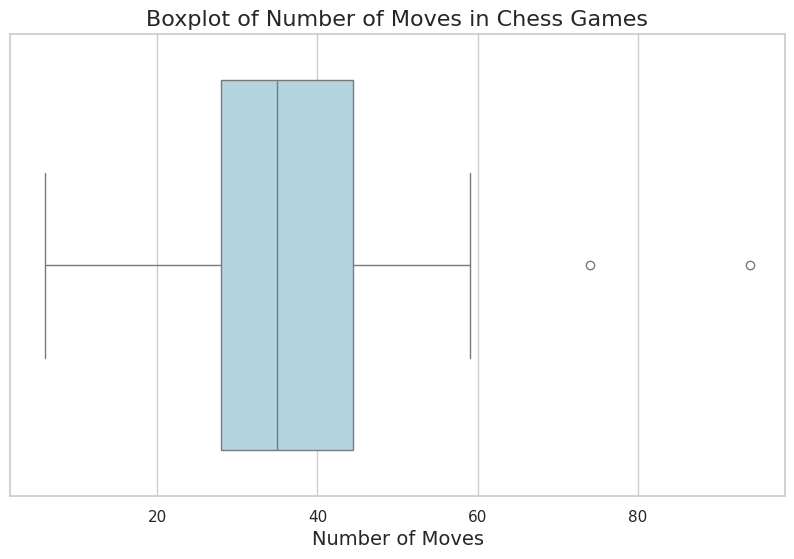

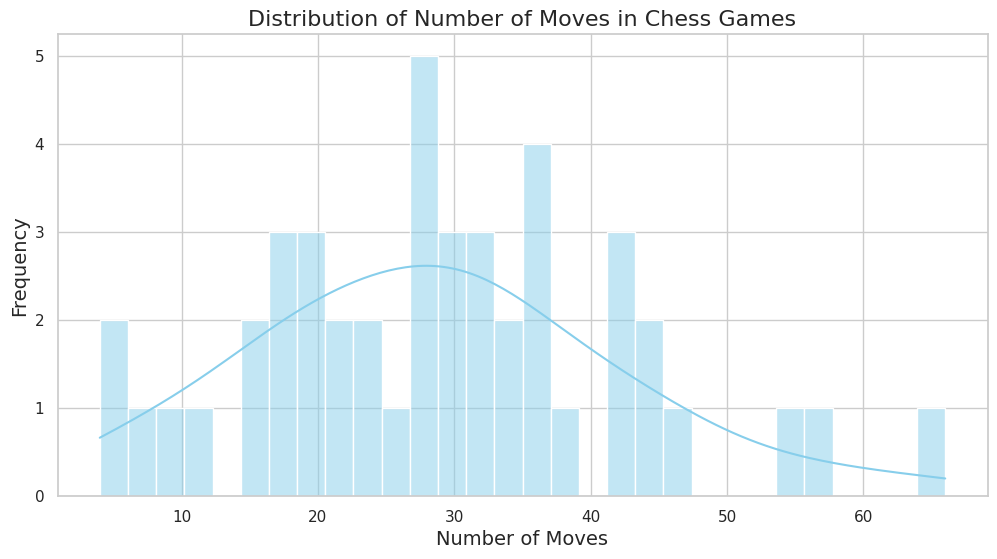

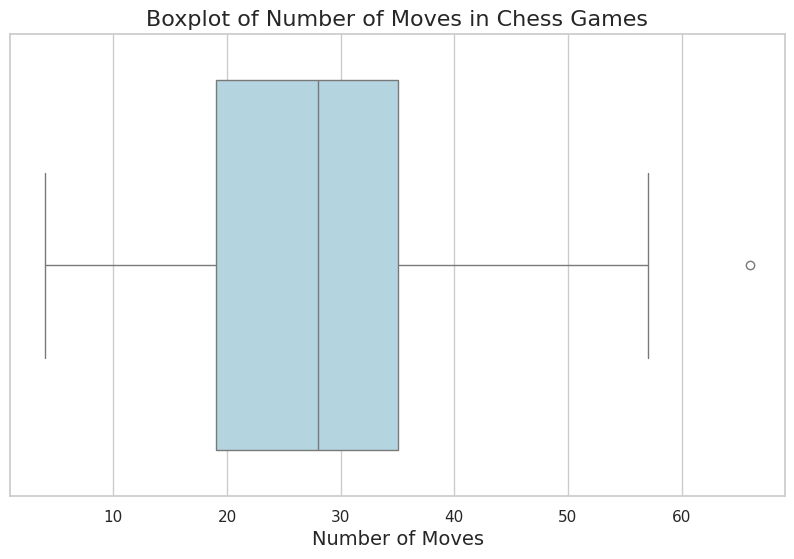

In [38]:
plot_histogram(gpt4_legal_games)
plot_boxplot(gpt4_legal_games)
plot_histogram(gpt35_instruct_legal_games)
plot_boxplot(gpt35_instruct_legal_games)

GPT4 is weaker than GPT35 instruct for legal moves
Yet GPT4 and GPT35 instruct are capable of winning a significant number of games (99%) when legal moves are played all along. 
GPT4 and GPT35 can play quite long games (resp. 28 moves and 35 moves on average).

In [39]:
# df_random.query("(white == 'gpt-4' or black == 'gpt-4') and has_illegal == False")
df_random['white'].value_counts()

white
gpt-4                     62
RANDOM chess engine       53
gpt-3.5-turbo-instruct    41
gpt-3.5-turbo             23
text-davinci-003          11
Name: count, dtype: int64

In [40]:
df_random.query("white == 'gpt-4' or black == 'gpt-4'")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
2,gpt-4,RANDOM chess engine,?,?,1-0,39,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game2869bc09-4bb0-42fa-af2f-c8780ba3fa4b,,False
12,gpt-4,RANDOM chess engine,?,?,1-0,37,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/gameb2c4363c-643e-47ee-b4ee-0035bf4915b5,,False
18,gpt-4,RANDOM chess engine,?,?,1-0,29,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game782c8352-4f23-401f-9e19-80d83471517d,,False
26,gpt-4,RANDOM chess engine,?,?,*,24,1,It is your turn! You have white pieces. Please...,0.0,True,True,Qxc8#,games/gamed4ecce8c-6c03-462d-a631-2a02ca21d421,,False
31,gpt-4,RANDOM chess engine,?,?,1-0,25,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game16b17b87-9c93-46ee-9aaa-7706bb5c0a28,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,gpt-4,RANDOM chess engine,?,?,1-0,37,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game9509dfaa-4025-4d3d-8591-913fc949af88,,False
817,gpt-4,RANDOM chess engine,?,?,1-0,39,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/gameb89d46a2-68ed-41a3-a791-c17223442dd8,,False
823,gpt-4,RANDOM chess engine,?,?,1-0,25,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/game20656fb3-8316-4d8e-92ea-4d508ec51101,,False
824,gpt-4,RANDOM chess engine,?,?,1-0,47,1,It is your turn! You have white pieces. Please...,0.0,True,False,,games/gamefd56635a-989e-4ce9-80d6-8e64c61eeeb8,,False


In [41]:
df_random.query("white != 'gpt-4' and black != 'gpt-4'").has_illegal.value_counts(), df_random.query("white == 'gpt-4' or black == 'gpt-4'").has_illegal.value_counts()

(has_illegal
 True     54
 False    51
 Name: count, dtype: int64,
 has_illegal
 False    59
 True     26
 Name: count, dtype: int64)

In [42]:
df_random.query("white != 'gpt-4' and black != 'gpt-4' and has_illegal == True")
df_random.query("white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo'")
df_random.query("(white == 'gpt-4' or black == 'gpt-4') and has_illegal == True")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
26,gpt-4,RANDOM chess engine,?,?,*,24,1,It is your turn! You have white pieces. Please...,0.0,True,True,Qxc8#,games/gamed4ecce8c-6c03-462d-a631-2a02ca21d421,,False
90,gpt-4,RANDOM chess engine,?,?,*,28,1,It is your turn! You have white pieces. Please...,0.0,True,True,Qd4,games/game1cedf899-6cb3-444f-b65c-c08a9495d221,,False
178,gpt-4,RANDOM chess engine,?,?,*,34,1,It is your turn! You have white pieces. Please...,0.0,True,True,Qxd8,games/game15deea9a-1f36-4793-8277-e46fc6a4af7c,,False
216,gpt-4,RANDOM chess engine,?,?,*,8,1,It is your turn! You have white pieces. Please...,0.0,True,True,5.,games/game789ed89f-1225-41e5-9c14-6e0810ef90df,,False
220,RANDOM chess engine,gpt-4,?,?,*,9,1,It is your turn! You have white pieces. Please...,0.0,True,True,Nxg4,games/game2b596bb9-a92f-4e8b-a657-e856bfd9cb2b,,False
250,gpt-4,RANDOM chess engine,?,?,*,20,1,It is your turn! You have white pieces. Please...,0.0,True,True,Qd5+,games/game67c52316-8f1d-4e4d-8f68-f10e83d8eff0,,False
289,gpt-4,RANDOM chess engine,?,?,*,10,1,It is your turn! You have white pieces. Please...,0.0,True,True,6.,games/game843ca850-a82d-48d1-940a-83e04e8b6c59,,False
291,gpt-4,RANDOM chess engine,?,?,*,30,1,It is your turn! You have white pieces. Please...,0.0,True,True,Qh5,games/game1932a9b8-216b-4815-9011-6977debf64b9,,False
295,RANDOM chess engine,gpt-4,?,?,*,33,1,It is your turn! You have white pieces. Please...,0.0,True,True,17...,games/gamedd90ac78-1f2f-4346-b68b-2b727c00da46,,False
299,RANDOM chess engine,gpt-4,?,?,*,33,1,It is your turn! You have white pieces. Please...,0.0,True,True,Rxg8,games/game1ab6fd05-977b-4411-ad66-afa6a230d232,,False


In [43]:
compute_score(df_random)

0.9888888888888889

In [44]:
df = df.query("random_engine == False")

In [45]:
df['temperature'].unique()

array([0. , 0.8, 0.2])

In [46]:
df.query('nstarting_move <= 2 and temperature == 0.0') # right now nmoves with 1 corresponds to traditional stuff... with 2 corresponds to basic, well-known, random openings and is fair... n > 2 corresponds to k random moves (and is a bit unfair for either side)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4,Stockfish,?,1871,*,26,1,It is your turn! You have white pieces. Please...,0.0,False,True,Rxe8,games/gameb1500052-f572-46c1-953f-f1ce35b85d90,,False
4,gpt-3.5-turbo-instruct,Stockfish,?,1694,0-1,160,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game6d27c5fc-4ded-49ca-9d6d-803b7a550b25,,True
6,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,110,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game70670e33-0a0b-419a-9b85-95df2ddcbe68,,True
10,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,90,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game93ff1998-3679-4c0e-a9be-692791cc6264,,True
13,gpt-3.5-turbo-instruct,Stockfish,?,2035,0-1,152,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game948a95b2-533a-42a9-9b59-b6222ecc5d12,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,Stockfish,gpt-4,1785,?,1-0,113,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/game00c7066d-51ea-4cbc-a305-3d094b8d8f33,,False
874,gpt-4,Stockfish,?,1597,0-1,178,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/gamec3fcef63-48ea-4acd-bfc9-c2b255634712,,False
875,Stockfish,gpt-4,1871,?,*,75,1,It is your turn! You have white pieces. Please...,0.0,False,True,Bg2,games/game573743ef-f4cf-4278-b30a-72f5beb84bfe,,False
876,Stockfish,gpt-4,1871,?,*,99,1,It is your turn! You have white pieces. Please...,0.0,False,True,Ke4,games/gamed861e427-7344-4980-8962-915f58e7c76a,,False


In [47]:
df.query('nstarting_move <= 2 and temperature == 0.8')

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
16,gpt-3.5-turbo-instruct,Stockfish,?,1694,1/2-1/2,163,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/game993d1b52-4f8e-4983-819f-4650382ab0d5,,True
27,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,True,{M.,games/game051d6c13-e880-49d1-9aac-6f19b81a0c62,,True
33,gpt-3.5-turbo-instruct,Stockfish,?,1694,0-1,110,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/gamebc9281cd-60f1-4e2f-8a8c-8d50350db0e6,,True
61,Stockfish,gpt-3.5-turbo-instruct,1871,?,*,63,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,True,1-0,games/gamebd29cc4e-cd5d-459b-af0c-5a06ecbbaa66,,True
73,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,118,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/gameb1439fa6-5d7a-439e-a1c7-ecae58626ed1,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,Stockfish,gpt-3.5-turbo-instruct,1871,?,1-0,75,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/gameb0292f61-af35-4f46-885b-3e6caf311d9c,,True
829,gpt-3.5-turbo-instruct,Stockfish,?,1694,0-1,150,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/gameb60af328-5b43-4c0a-ba5c-e6a5f093fb74,,True
836,gpt-3.5-turbo-instruct,Stockfish,?,1785,0-1,42,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/game5bcadcea-ce4d-4379-89fc-04969231a4f2,,True
841,Stockfish,gpt-3.5-turbo-instruct,1785,?,1-0,103,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/game89763b2e-d6a7-4617-a4d8-1c304f72ee8a,,True


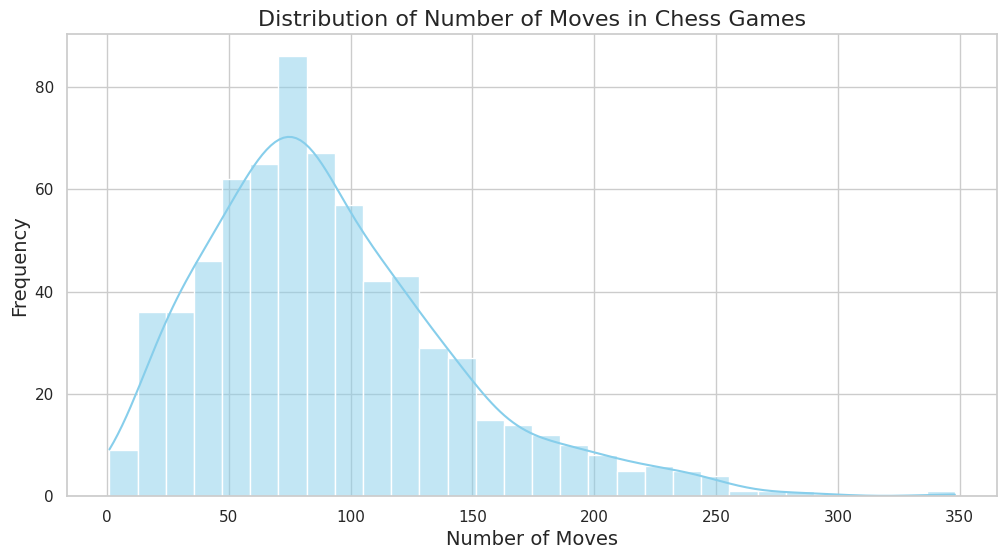

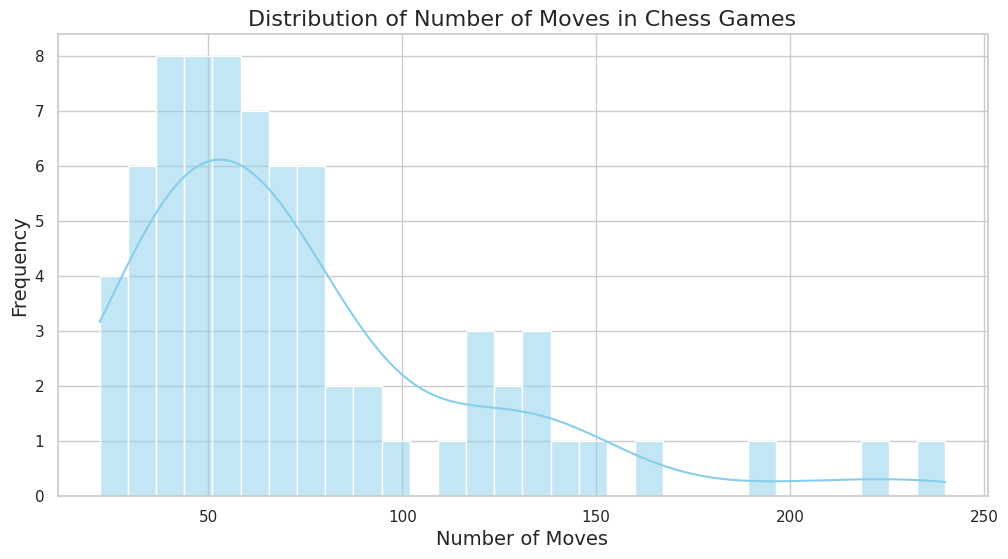

In [48]:


plot_histogram(df)
plot_histogram(df.query('nstarting_move > 2'))


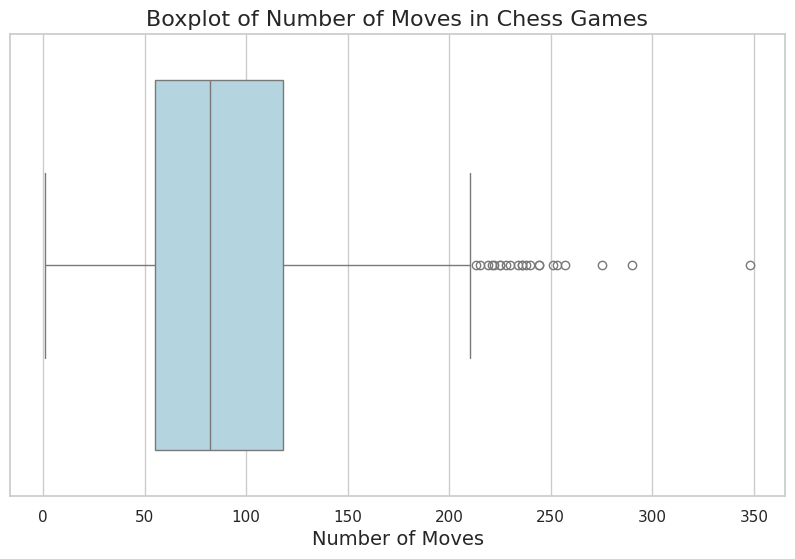

In [49]:


plot_boxplot(df)


In [50]:
def compute_average(df, model_name='gpt-3.5-turbo-instruct'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Convert Elo columns to numeric, setting errors='coerce' to handle non-numeric values
    df_copy['white_elo'] = pd.to_numeric(df_copy['white_elo'], errors='coerce')
    df_copy['black_elo'] = pd.to_numeric(df_copy['black_elo'], errors='coerce')

    # Filter out rows where gpt-3.5-turbo-instruct is the player and get the opponent's Elo
    opponent_elo_white = df_copy[df_copy['white'] == model_name]['black_elo']
    opponent_elo_black = df_copy[df_copy['black'] == model_name]['white_elo']

    # Concatenate the Elo ratings of opponents when gpt-3.5-turbo-instruct played as white and black
    all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])

    # Calculate the average Elo rating of the opponents, excluding missing or NaN values
    average_opponent_elo = all_opponent_elo.mean()

    return average_opponent_elo


In [51]:
from scipy.optimize import fsolve
import numpy as np


def computation_Elo(df,  initial_guess = 1700, model_name='gpt-3.5-turbo-instruct', K=400):
    # Given values
    S_A = compute_score(df, model_name)  # The score of Player A
    R_B = compute_average(df, model_name)  # The rating of Player 

    # Define the equation to solve for R_A
    def equation(R_A, *data):
        S_A, R_B = data
        return S_A - 1 / (1 + 10**((R_B - R_A) / K)) 

    # Solve the equation for R_A
    R_A_solution = fsolve(equation, initial_guess, args=(S_A, R_B))

    # Extract the calculated R_A value
    R_A_calculated = float(R_A_solution[0])
    return R_A_calculated

computation_Elo(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct')")), computation_Elo(df.query('nstarting_move <= 2 and temperature == 0.0')), computation_Elo(df.query('nstarting_move <= 2 and temperature == 0.8')), computation_Elo(df.query('nstarting_move > 2 and temperature == 0.0'))


/tmp/ipykernel_128563/3600239167.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])


(1747.8626258554725, 1785.4345248666352, 1584.2638713688007, 1433.464744474366)

In [52]:

# rs = []
# for i in range(0, 1000):
#     rs.append(compute_elo(df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False").sample(), candidate_name="gpt-3.5-turbo-instruct", starting_elo=1500, K=400))


def lookup_fide_table(score):
        # Data here: https://handbook.fide.com/chapter/B022017
        data = {
            'p': [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .90, .89, .88, .87, .86, .85, .84,
                .83, .82, .81, .80, .79, .78, .77, .76, .75, .74, .73, .72, .71, .70, .69, .68, .67,
                .66, .65, .64, .63, .62, .61, .60, .59, .58, .57, .56, .55, .54, .53, .52, .51, .50,
                .49, .48, .47, .46, .45, .44, .43, .42, .41, .40, .39, .38, .37, .36, .35, .34, .33,
                .32, .31, .30, .29, .28, .27, .26, .25, .24, .23, .22, .21, .20, .19, .18, .17, .16,
                .15, .14, .13, .12, .11, .10, .09, .08, .07, .06, .05, .04, .03, .02, .01],
            'dp': [800, 677, 589, 538, 501, 470, 444, 422, 401, 383, 366, 351, 336, 322, 309, 296, 284,
                273, 262, 251, 240, 230, 220, 211, 202, 193, 184, 175, 166, 158, 149, 141, 133, 125,
                117, 110, 102, 95, 87, 80, 72, 65, 57, 50, 43, 36, 29, 21, 14, 7, 0, -7, -14, -21, 
                -29, -36, -43, -50, -57, -65, -72, -80, -87, -95, -102, -110, -117, -125, -133, -141,
                -149, -158, -166, -175, -184, -193, -202, -211, -220, -230, -240, -251, -262, -273, 
                -284, -296, -309, -322, -336, -351, -366, -383, -401, -444, -470, -501, -538, -589, -677, -800]
        }

        # Convert to DataFrame
        df_fide = pd.DataFrame(data)

        rscore = round(score, 2)

        # lookup score in table
        dp = df_fide.loc[df_fide['p'] == rscore, 'dp'].iloc[0]
        return dp

def fide_elo_computation(dfe, model_name, score=None):
    average_opponents_ratings = compute_average(dfe, model_name)
    if score is None:
        score = compute_score(dfe, model_name)
    dp = lookup_fide_table(score)


    return average_opponents_ratings + dp

                    
def compute_elo(df_l, model_gpt_name):
    df_elo = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False")
    fide_elo_value = round(fide_elo_computation(df_elo, model_gpt_name), 0)
    print(f"{fide_elo_value} Elo for {model_gpt_name} against SF and only with legal games/moves")
    
    df_elo_withillegal = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")
    s, t = compute_score(df_elo_withillegal, model_gpt_name, percentage=False)
    sc = s / len(df_elo_withillegal)
    fide_elo_with_illegal_value = round(fide_elo_computation(df_elo_withillegal, model_gpt_name, sc), 0)
    print(f"{fide_elo_with_illegal_value} Elo for {model_gpt_name} against SF and with all games")

# Usage:
compute_elo(df_non_random, 'gpt-3.5-turbo-instruct')
compute_elo(df_non_random, 'gpt-4')

print("With temperature=0")
df_non_random['temperature'] = df_non_random['temperature'].astype(float)
compute_elo(df_non_random.query("temperature == 0.0"), 'gpt-3.5-turbo-instruct')
print("With temperature=0.8")
compute_elo(df_non_random.query("temperature != 0"), 'gpt-3.5-turbo-instruct')




1743.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1696.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
1371.0 Elo for gpt-4 against SF and only with legal games/moves
1305.0 Elo for gpt-4 against SF and with all games
With temperature=0
1789.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1742.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
With temperature=0.8
1573.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1519.0 Elo for gpt-3.5-turbo-instruct against SF and with all games


In [53]:
print("Elo with altered prompt")
compute_elo(df_non_random.query("pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')
# compute_elo(df_non_random.query("pgn_base.str.contains('Rennes FRA')").query("temperature == 0.0"), 'gpt-3.5-turbo-instruct')
print("we don't have interactions temperature/altered prompt")
# compute_elo(df_non_random.query("pgn_base.str.contains('Rennes FRA')").query("temperature == 0.8"), 'gpt-3.5-turbo-instruct')

print("Elo with non altered prompt")
compute_elo(df_non_random.query("not pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')
print("Elo with non altered prompt, t=0")
compute_elo(df_non_random.query("not pgn_base.str.contains('Rennes FRA')").query("temperature == 0.0"), 'gpt-3.5-turbo-instruct')
print("Elo with non altered prompt, t=0.8")
compute_elo(df_non_random.query("not pgn_base.str.contains('Rennes FRA')").query("temperature == 0.8"), 'gpt-3.5-turbo-instruct')

Elo with altered prompt
1808.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1752.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
we don't have interactions temperature/altered prompt
Elo with non altered prompt
1729.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1681.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
Elo with non altered prompt, t=0
1778.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1744.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
Elo with non altered prompt, t=0.8
1572.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1518.0 Elo for gpt-3.5-turbo-instruct against SF and with all games


In [54]:
df_elo_onlywhite = df_non_random.query("(white == 'gpt-3.5-turbo-instruct') and `has_illegal` == False")
print(round(fide_elo_computation(df_elo_onlywhite, 'gpt-3.5-turbo-instruct'), 0), "Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with white pieces")

df_elo_onlywhite_withillegal = df_non_random.query("(white == 'gpt-3.5-turbo-instruct')")
mname = 'gpt-3.5-turbo-instruct'
s, t = compute_score(df_elo_onlywhite_withillegal, mname, percentage=False)
sc = s / len(df_elo_onlywhite_withillegal)
print(round(fide_elo_computation(df_elo_onlywhite_withillegal, mname, sc), 0), "Elo for", mname, "against SF and with all games and only with white pieces")

# only black
df_elo_onlyblack_withillegal = df_non_random.query("(black == 'gpt-3.5-turbo-instruct')")
mname = 'gpt-3.5-turbo-instruct'
s, t = compute_score(df_elo_onlyblack_withillegal, mname, percentage=False)
sc = s / len(df_elo_onlyblack_withillegal)
print(round(fide_elo_computation(df_elo_onlyblack_withillegal, mname, sc), 0), "Elo for", mname, "against SF and with all games and only with black pieces")

# only black
df_elo_onlyblack = df_non_random.query("(black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False")
print(round(fide_elo_computation(df_elo_onlyblack, 'gpt-3.5-turbo-instruct'), 0), "Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with black pieces")



1725.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with white pieces
1715.0 Elo for gpt-3.5-turbo-instruct against SF and with all games and only with white pieces
1671.0 Elo for gpt-3.5-turbo-instruct against SF and with all games and only with black pieces
1809.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves and only with black pieces


/tmp/ipykernel_128563/3600239167.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])
/tmp/ipykernel_128563/3600239167.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])
/tmp/ipykernel_128563/3600239167.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavio

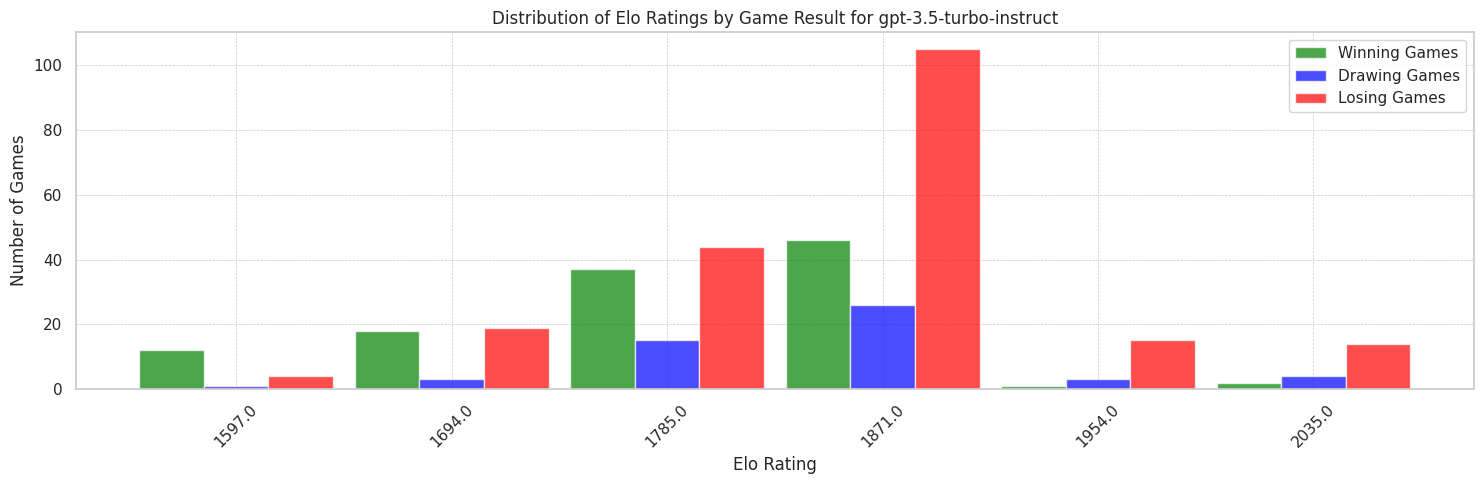

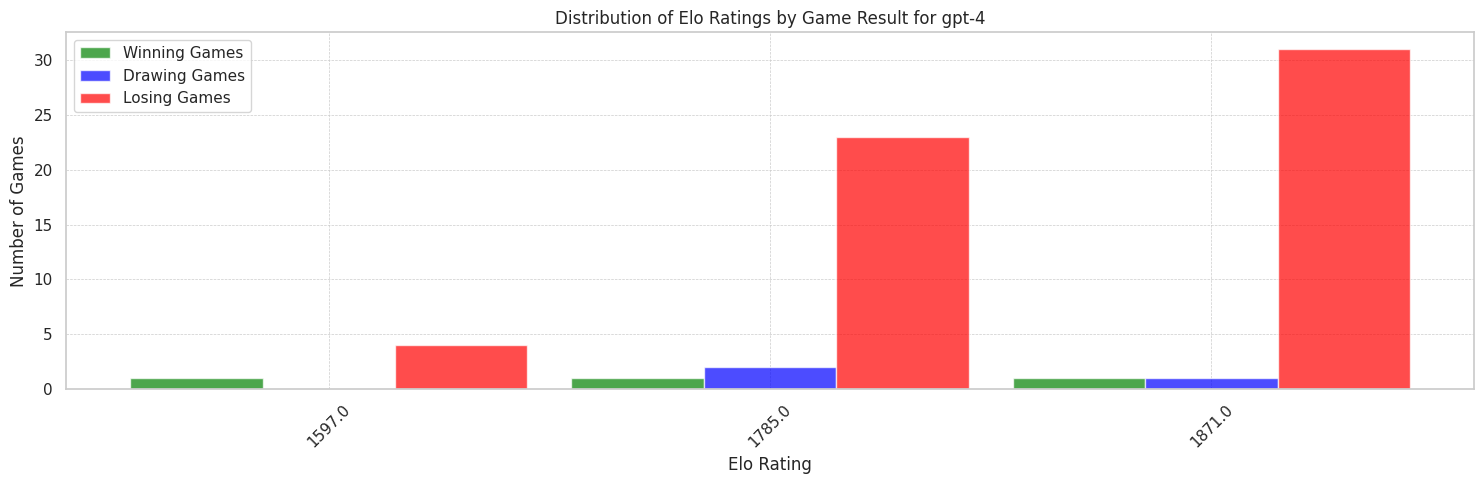

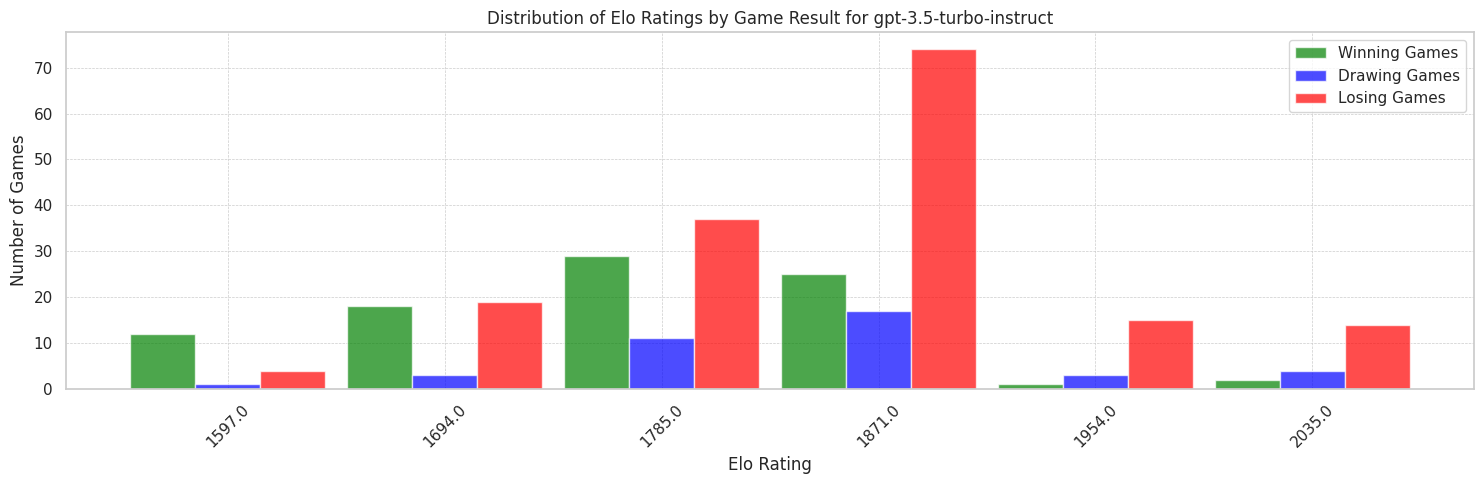

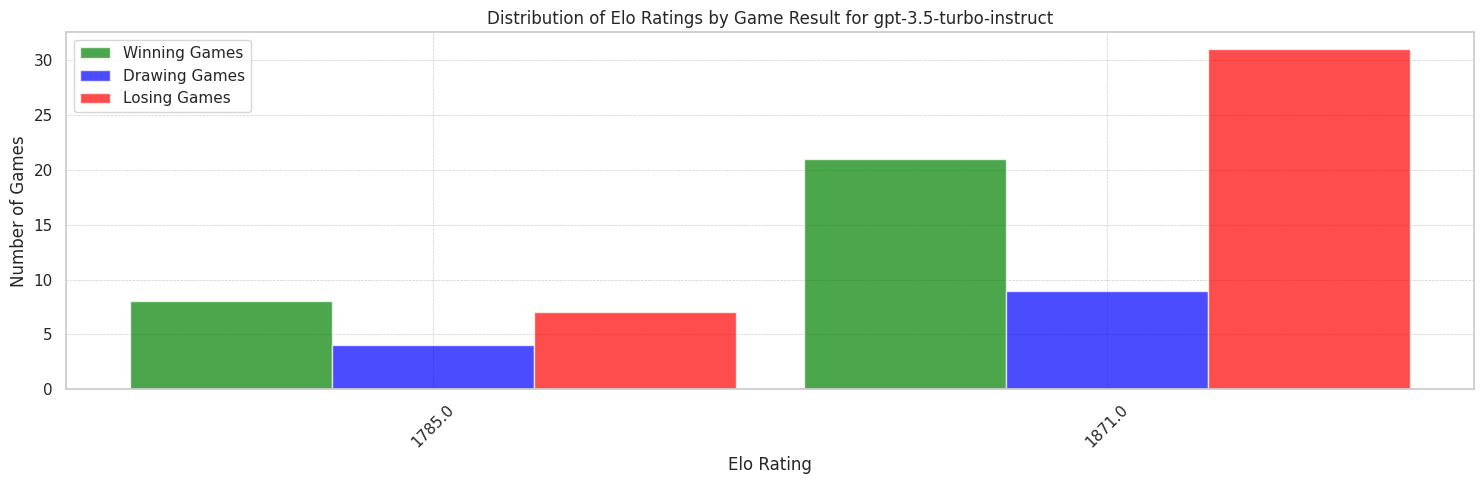

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def extract_elo_ratings(df_l, model_gpt_name):
    wrs = [] # winning games 
    lrs = [] # losing games
    drs = [] # drawing games
    
    # Filter and iterate over the dataframe
    for _, row in df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False").iterrows():
        if row['white'] == model_gpt_name and row['result'] == '1-0':
            wrs.append(row['black_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '0-1':
            wrs.append(row['white_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '1-0':
            lrs.append(row['white_elo'])
        elif row['white'] == model_gpt_name and row['result'] == '0-1':
            lrs.append(row['black_elo'])
        elif row['result'] == '1/2-1/2':
            if row['white'] == model_gpt_name:
                drs.append(row['black_elo'])
            else:
                drs.append(row['white_elo'])
        else:
            print("warning")
            print(row)
            continue

    wrs = [float(val) for val in wrs]
    lrs = [float(val) for val in lrs]
    drs = [float(val) for val in drs]
    
    return wrs, lrs, drs

def plot_elo_distribution(wrs, lrs, drs, model_gpt_name):
    # Compute unique Elos and their counts
    unique_elos = sorted(np.unique(wrs))
    win_counts = [wrs.count(elo) for elo in unique_elos]
    draw_counts = [drs.count(elo) for elo in unique_elos]
    lose_counts = [lrs.count(elo) for elo in unique_elos]

    # Plotting
    bar_width = 0.3
    index = np.arange(len(unique_elos))
    plt.figure(figsize=(15, 5))
    plt.bar(index, win_counts, bar_width, alpha=0.7, color='green', label='Winning Games')
    plt.bar(index + bar_width, draw_counts, bar_width, alpha=0.7, color='blue', label='Drawing Games')
    plt.bar(index + 2 * bar_width, lose_counts, bar_width, alpha=0.7, color='red', label='Losing Games')

    plt.xlabel('Elo Rating')
    plt.ylabel('Number of Games')
    plt.title(f'Distribution of Elo Ratings by Game Result for {model_gpt_name}')

    plt.xticks(index + bar_width, unique_elos, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"elo_distribution-scores-{model_gpt_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

def analyze_and_plot_elo_distribution(df_l, model_gpt_name):
    wrs, lrs, drs = extract_elo_ratings(df_l, model_gpt_name)
    plot_elo_distribution(wrs, lrs, drs, model_gpt_name)



# Return the functions for further use
analyze_and_plot_elo_distribution(df_non_random, "gpt-3.5-turbo-instruct")
analyze_and_plot_elo_distribution(df_non_random, "gpt-4")
# df_non_random


analyze_and_plot_elo_distribution(df_non_random.query("not pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')
analyze_and_plot_elo_distribution(df_non_random.query("pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')






In [56]:
final_elo = fide_elo_computation(df.query('nstarting_move <= 2 and temperature == 0.0'), 'gpt-3.5-turbo-instruct') # starting_elo=1700, K=40)
print(f"Final Elo of gpt-3.5-turbo-instruct with white: {final_elo}")



Final Elo of gpt-3.5-turbo-instruct with white: 1787.4658753709198


In [57]:
for k, v in df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False").iterrows():
    if v['white'] == "gpt-3.5-turbo-instruct" and v['black_elo'] != '?':
            opponent_elo = float(v['black_elo'])
    elif v['black'] == "gpt-3.5-turbo-instruct" and v['white_elo'] != '?':
        opponent_elo = float(v['white_elo'])
    else:
        print("warning: no elo found for opponent", k, v['folder_name'])
        continue
    result = v['result']
    if result == '*':
        print("warning: no result found for opponent", k, v['folder_name'])
        continue

In [58]:
len(df.query('nstarting_move > 2'))

73

In [59]:
df.query('nstarting_move > 2')

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
3,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,34,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game52d0e78b-e22f-40b4-b50b-81da4155df26,1. f4 h5 2. Na3 g5 3. b3 a5 4. c4 Na6 5. Kf2 h...,True
23,gpt-3.5-turbo-instruct,Stockfish,?,1871,1/2-1/2,240,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game43e6ca3c-6bf4-4f2d-85b5-f361d6b7893c,1. e3 a6 2. Qh5 g5 3. Qh4 h6 4. g4 Rh7 5. b3 b...,True
25,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,78,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/gameade0ecb6-9097-43d2-b713-72c103725cb1,1. f4 Na6 2. a4 e6 3. d3 Nc5 4. Bd2 Rb8 5. Na3...,True
34,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,38,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game1f33c9a7-3c36-460c-8ee9-2a6e2fbae548,1. Na3 g6 2. Nh3 h6 3. Rg1 Rh7 4. Nf4 g5 5. e3...,True
54,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,110,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/gamef2a16e47-13fd-4f2a-a943-7adf0b7ba1ce,1. f4 a5 2. Nc3 Nh6 3. b3 f6 4. a4 Rg8 5. Nb1 ...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,gpt-3.5-turbo-instruct,Stockfish,?,1785,0-1,22,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game7f234286-8554-4440-a3fb-b5e0730486ff,1. g3 f6 2. a4 g6 3. c4 Kf7 4. Ra3 Bh6 5. f4 e...,True
811,gpt-3.5-turbo-instruct,Stockfish,?,1785,0-1,222,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/gamef34178c6-120d-42cb-8688-5769cf80c2af,1. g4 Nh6 2. c4 c5 3. f3 f5 4. Qc2 d5 5. e3 dx...,True
818,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,30,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game1ab8281a-021d-4ccd-9e45-512f345077ec,1. e4 g5 2. b4 d5 3. Qh5 Bd7 4. d3 a6 5. Bd2 c...,True
834,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,68,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game50dc4e84-fbbc-40c7-b6f5-30fb89fd1759,1. c3 b6 2. Qa4 Na6 3. a3 f6 4. Qc2 c6 5. f3 g...,True


In [60]:
df['has_illegal'].unique()

array([True, False], dtype=object)

In [61]:
df['illegal_move'].value_counts()

illegal_move
         507
1-0       49
1-         4
O-O        3
Rxe8       2
        ... 
bxc8=      1
Qg5        1
Kxd6       1
Bxd6+      1
Ke4        1
Name: count, Length: 117, dtype: int64

In [62]:
df['base_pgn_prompt'].value_counts()

base_pgn_prompt
True     445
False    243
Name: count, dtype: int64

In [63]:
computation_Elo(df.query('base_pgn_prompt == False'))

1814.3735994559265

In [64]:
df.query("(white == 'gpt-4' or black == 'gpt-4')")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4,Stockfish,?,1871,*,26,1,It is your turn! You have white pieces. Please...,0.0,False,True,Rxe8,games/gameb1500052-f572-46c1-953f-f1ce35b85d90,,False
15,gpt-4,Stockfish,?,1785,0-1,100,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/game1f7e89ae-f10a-4394-8843-1b3b79ac7273,,False
35,gpt-4,Stockfish,?,1871,0-1,56,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/game1add708f-c048-4869-8eb2-21f486e7c413,,False
45,gpt-4,Stockfish,?,1871,0-1,56,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/game58320057-f5e1-4a1a-991c-c59c6483fd1c,,False
58,gpt-4,Stockfish,?,1785,*,66,1,It is your turn! You have white pieces. Please...,0.0,False,True,Kg3,games/gamee7a83d26-2478-4c34-98d1-3cf65037a797,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,Stockfish,gpt-4,1785,?,1-0,113,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/game00c7066d-51ea-4cbc-a305-3d094b8d8f33,,False
874,gpt-4,Stockfish,?,1597,0-1,178,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/gamec3fcef63-48ea-4acd-bfc9-c2b255634712,,False
875,Stockfish,gpt-4,1871,?,*,75,1,It is your turn! You have white pieces. Please...,0.0,False,True,Bg2,games/game573743ef-f4cf-4278-b30a-72f5beb84bfe,,False
876,Stockfish,gpt-4,1871,?,*,99,1,It is your turn! You have white pieces. Please...,0.0,False,True,Ke4,games/gamed861e427-7344-4980-8962-915f58e7c76a,,False


In [65]:
df.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
14,gpt-3.5-turbo,Stockfish,?,1871,*,14,1,It is your turn! You have white pieces. Please...,0.0,False,True,cxd6,games/game9a01a28b-0b9b-4ac7-a27a-635ddcac67cb,,False
43,gpt-3.5-turbo,Stockfish,?,1694,*,22,1,It is your turn! You have white pieces. Please...,0.0,False,True,O-O,games/gameab89e6f2-378c-4e94-b94e-027d55a90472,,False
51,gpt-3.5-turbo,Stockfish,?,1871,*,26,1,It is your turn! You have white pieces. Please...,0.0,False,True,Rxh1,games/game0646c65e-786d-4c0a-8cb0-46883c81cee7,,False
81,gpt-3.5-turbo,Stockfish,?,1694,*,16,1,It is your turn! You have white pieces. Please...,0.0,False,True,Bxc6,games/gamefdb72f62-aaf6-40dd-98de-7f6f4bc6a405,,False
96,gpt-3.5-turbo,Stockfish,?,1871,*,46,1,It is your turn! You have white pieces. Please...,0.0,False,True,c4,games/game000df145-c8f1-4570-a57f-d8d79807d0fa,,False
108,gpt-3.5-turbo,Stockfish,?,1694,*,58,1,It is your turn! You have white pieces. Please...,0.0,False,True,Qxe4,games/game5cae331f-043b-488f-8240-3833e30db899,,False
114,gpt-3.5-turbo,Stockfish,?,1694,*,16,1,It is your turn! You have white pieces. Please...,0.0,False,True,exd6,games/game39b35c3c-e08e-4d1e-a7a0-b5af1188c32f,,False
116,gpt-3.5-turbo,Stockfish,?,1871,*,38,1,It is your turn! You have white pieces. Please...,0.0,False,True,Bxh6,games/gameaec9eb9a-3ce6-4e51-af85-b2d1b5432a58,,False
118,gpt-3.5-turbo,Stockfish,?,1871,*,30,1,It is your turn! You have white pieces. Please...,0.0,False,True,Qxe4,games/game5f552356-e569-481a-8bdf-1dafa5cad6b5,,False
162,gpt-3.5-turbo,Stockfish,?,1871,0-1,50,1,It is your turn! You have white pieces. Please...,0.0,False,False,,games/gamea9168c1b-a985-4794-b8cf-f68cdbf2122b,,False


In [66]:
computation_Elo(df.query("(white == 'gpt-4' or black == 'gpt-4') and has_illegal == False"), model_name='gpt-4')

1366.1344692187176